Neural Point Processes - Gaussian Processes

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import io, transform
from functools import lru_cache
from tools.plot_utils import visualize_pins, plot_label_pin, plot_all, plot_and_save, plot_loss
from tools.data_utils import *
from tools.losses import NPPLoss
from tools.models import Autoencoder
from tools.optimization import EarlyStoppingCallback, train_model, evaluate_model
import matplotlib.pyplot as plt
from torch_lr_finder import LRFinder
import time
from tools.models import *
from torch.utils.data import Subset

# Dataset and Visualization

In [2]:
# Set a random seed for PyTorch
seed = 4  # You can use any integer value as the seed
torch.manual_seed(seed)
# Set a random seed for NumPy (if you're using NumPy operations)
np.random.seed(seed)

In [30]:
dataset = "Building"
feature_extracted = False
mesh = False
d = 10
n_pins = 100
batch_size = 32

if feature_extracted:
    folder = f"{dataset}_ddpm"
else:
    folder = f"{dataset}"

if dataset == "PinMNIST":
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}step_{28}by{28}pixels_{r}radius_{seed}seed"
        config['n_pins'] = (28 // d + 1) ** 2
    else:
        data_folder = f"./data/{folder}/random_fixedTrue_{n_pins}pins_{28}by{28}pixels_{r}radius_{seed}seed"
elif dataset == "Synthetic":
    folder += "/28by28pixels_1000images_123456seed"
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}step_pins"
        config['n_pins'] = (28 // d + 1) ** 2
    else:
        data_folder = f"./data/{folder}/random_{n_pins}pins"
elif dataset == "Building":
    if mesh:
        data_folder = f"/work/DNAL/ozcan.g/SatelliteFusion/Satellite_Fusion/data/{folder}/processed/mesh_{d}_step"
    else:
        data_folder = f"/work/DNAL/ozcan.g/SatelliteFusion/Satellite_Fusion/data/{folder}/processed/random_n_pins_{n_pins}"


In [41]:
def custom_collate_fn(batch):
    images = [sample['image'] for sample in batch]
    pins = [sample['pins'] for sample in batch]
    outputs = [sample['outputs'] for sample in batch]

    return {
        'image': torch.stack(images, dim=0),
        'pins': pins,
        'outputs': outputs}


if dataset == "Building":
    resize = Resize100
else:
    resize = Resize
        
transform = transforms.Compose([
    ToTensor(),  # Convert to tensor (as you were doing)
    resize()  # Resize to 100x100
])

transformed_dataset = PinDataset(csv_file=f"{data_folder}/pins.csv",
                                 root_dir=f"./data/{folder}/processed/images/",
                                 transform=transform)

dataset_size = len(transformed_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.10 * dataset_size)
test_size = dataset_size - train_size - val_size


if os.path.exists(f"./data/{dataset}/train_indices.npy"):
    train_indices = np.load(f'./data/{dataset}/train_indices.npy')
    val_indices = np.load(f'./data/{dataset}/val_indices.npy')
    test_indices = np.load(f'./data/{dataset}/test_indices.npy')
    # Use the indices to create new datasets
    train_dataset = Subset(transformed_dataset, train_indices)
    val_dataset = Subset(transformed_dataset, val_indices)
    test_dataset = Subset(transformed_dataset, test_indices)
else:
    # Split the dataset into train, validation, and test sets
    train_dataset, val_dataset, test_dataset = random_split(
        transformed_dataset, [train_size, val_size, test_size]
    )
    np.save(f'./data/{dataset}/train_indices.npy', train_dataset.indices)
    np.save(f'./data/{dataset}/val_indices.npy', val_dataset.indices)
    np.save(f'./data/{dataset}/test_indices.npy', test_dataset.indices)

# Create your DataLoader with the custom_collate_fn
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for batch in train_loader:
    images = batch['image'].to(device) # get RGB instead of RGBA
    pins = batch['pins']
    outputs = batch['outputs']

torch.Size([1, 100, 100]) torch.Size([100, 100, 1])


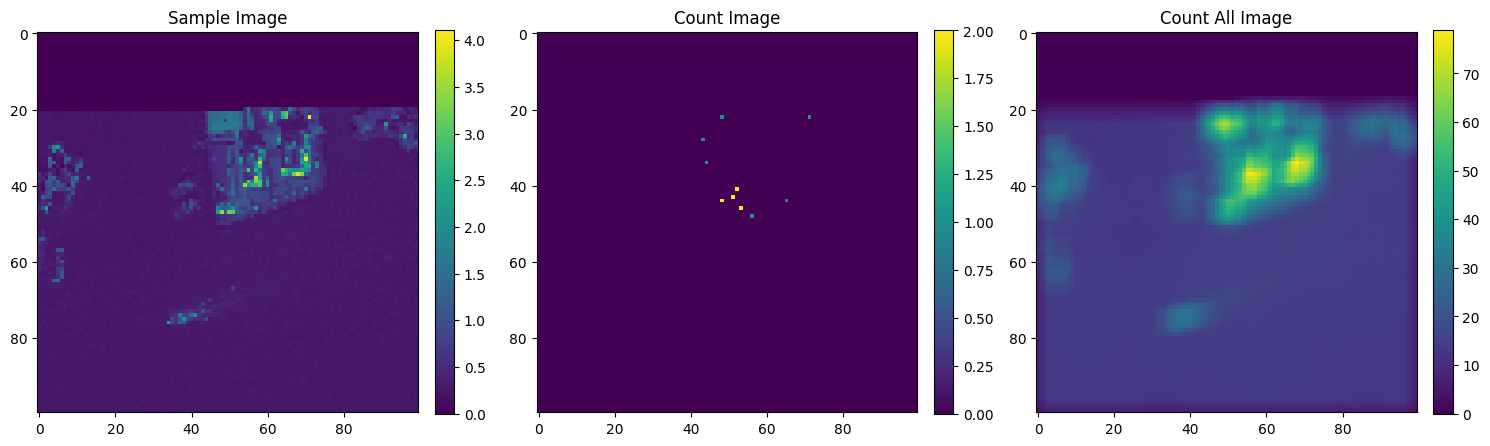

In [43]:
j=6
sample_img = images[j].squeeze().detach().cpu()
count_image = plot_label_pin(sample_img[0], pins[j], outputs[j])
count_all_image = plot_all(sample_img[0], r=3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sample_img = sample_img[:1]
img = np.transpose(sample_img, (1, 2, 0))
print(sample_img.shape, img.shape)
im0 = axes[0].imshow(img)
# Plot the sample_img in the first subplot
# im0 = axes[0].imshow(sample_img)
axes[0].set_title('Sample Image')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)  # Add colorbar

# Plot the count_image in the second subplot
im1 = axes[1].imshow(count_image)
axes[1].set_title('Count Image')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)  # Add colorbar

# Plot the count_all_image in the third subplot
im2 = axes[2].imshow(count_all_image)
axes[2].set_title('Count All Image')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)  # Add colorbar

# Add spacing between subplots
plt.tight_layout()
# Display the figure
plt.show()

# Training

In [44]:
print(autoencoder_MSE)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3

In [48]:
input_channel = 4
epochs = 200
sigmas = [0.1, 0.2, 0.5, 1, 2, 5, 10]  
num_kernels_encoder = [64, 32]
num_kernels_decoder = [64]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeper = True
exp_name = "Best_Building"
experiment_id = "random_dense"

data_loader = val_loader

autoencoder_MSE = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel, deeper=deeper).to(device)
autoencoder_NPP = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel, deeper=deeper).to(device)
# Load models
try:
    autoencoder_MSE.load_state_dict(torch.load(f'./history/{exp_name}/{experiment_id}/best_model_MSE.pth'))
    autoencoder_NPP.load_state_dict(torch.load(f'./history/{exp_name}/{experiment_id}/best_model_NPP.pth'))
except:
    raise Exception(
        "The model you provided does not correspond with the selected architecture. Please revise and try again.")

MSE_loss, R2_MSE =  evaluate_model(autoencoder_MSE, data_loader, input_channel, device,
                                                           partial_label_GP=False)
NPP_loss, R2_NPP = evaluate_model(autoencoder_NPP, data_loader, input_channel, device,
                                           partial_label_GP=False)

print(f"PLP: 0  MSE loss {MSE_loss} R2 {R2_MSE} NPP loss {NPP_loss} R2 {R2_NPP}")
# NPP
for percent in [0.25, 0.50, 0.75, 1.00]:
    print(f'Percent testing {percent}')
    GP_loss, R2_GP = evaluate_model(autoencoder_NPP, data_loader, input_channel, device,
                                              partial_label_GP=True, partial_percent=percent)
    print(f"PLP: {percent} GP loss {GP_loss} R2 {R2_GP}")

PLP: 0  MSE loss 1.4681792110204697 R2 -0.7656200896017253 NPP loss 1.9067236185073853 R2 -0.7852067407220602
Percent testing 0.25
PLP: 0.25 GP loss 2.3207228779792786 R2 -0.6652501374483109
Percent testing 0.5
PLP: 0.5 GP loss 1.451132446527481 R2 -0.7318784012459219
Percent testing 0.75
PLP: 0.75 GP loss 1.561173141002655 R2 -0.6204233132302761
Percent testing 1.0
PLP: 1.0 GP loss 1.2968632951378822 R2 -1.260552180930972
